In [22]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
import pickle
from pathlib import Path

# May require pip installation
from tqdm.auto import tqdm

from importlib import reload

import sys
sys.path.append("../src")

import utils

In [2]:
plt.rcParams.update({'font.size': 22,'figure.figsize': (12, 8)})
plt.style.use("seaborn")
f_path = Path("../data/bank-full.csv")
df = pd.read_csv(f_path, delimiter=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
RANDOM_STATE = 42
import utils
reload(utils)

X_train, X_test, y_train, y_test, scaler = utils.preprocess(df, random_state=RANDOM_STATE)
X_train

,day,campaign,pdays,previous,age_transf,balance_transf,duration_transf,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
41626,25,1,-1,0,1.041921,-0.408664,-0.594750,0,0,0,...,0,0,0,0,0,0,1,0,0,1
31347,16,13,-1,0,-1.218254,-0.296667,-0.680179,0,0,0,...,0,0,1,0,0,0,0,0,0,1
22563,22,1,-1,0,-0.464863,-0.396183,-0.528737,0,0,0,...,0,0,0,0,0,0,0,0,0,1
37243,13,1,-1,0,1.324443,-0.341334,-0.225854,0,1,0,...,0,0,0,1,0,0,0,0,0,1
32259,16,1,339,1,-0.276515,-0.150513,0.399328,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,18,1,-1,0,0.288529,-0.099605,7.124890,0,0,1,...,0,1,0,0,0,0,0,0,0,1
44732,8,1,92,1,-1.689124,-0.280574,-0.187023,0,0,0,...,0,0,0,0,0,0,1,0,0,0
38158,15,1,-1,0,-0.653211,-0.014869,-0.074413,0,0,0,...,0,0,0,1,0,0,0,0,0,1
860,7,1,-1,0,-0.747384,-0.393227,-0.571452,0,0,0,...,0,0,0,1,0,0,0,0,0,1


# Baseline model

In [4]:
%%time
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

Wall time: 9.54 s


RandomForestClassifier(random_state=42)

# Drop Low Importance Features

In [5]:
rf.feature_importances_

array([0.08675887, 0.03959975, 0.03985896, 0.02130274, 0.09982627,
       0.10018569, 0.27370845, 0.00922896, 0.00376526, 0.00326062,
       0.01074492, 0.00514691, 0.0047974 , 0.0066915 , 0.00449854,
       0.01162975, 0.00473711, 0.00145877, 0.01159985, 0.00946313,
       0.01333707, 0.01223793, 0.00573606, 0.00205064, 0.0203904 ,
       0.01027622, 0.00742805, 0.0141678 , 0.01087537, 0.00402727,
       0.0079943 , 0.00572567, 0.00976103, 0.0110927 , 0.01287982,
       0.010605  , 0.00899749, 0.0108499 , 0.00838603, 0.00390253,
       0.05340802, 0.00760727])

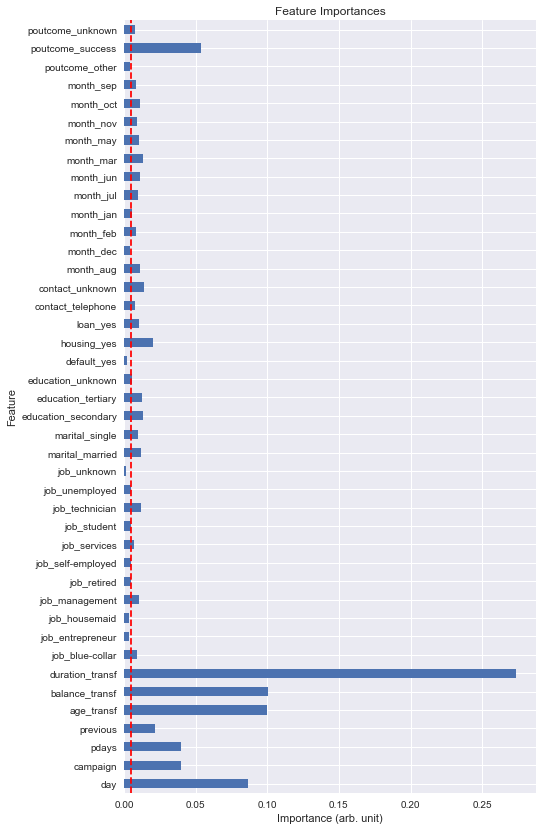

job_entrepreneur     0.003765
job_housemaid        0.003261
job_self-employed    0.004797
job_student          0.004499
job_unemployed       0.004737
job_unknown          0.001459
default_yes          0.002051
month_dec            0.004027
poutcome_other       0.003903
Name: Feature Importances, dtype: float64

In [6]:
reload(utils)
low_features = utils.plot_feature_importances(rf.feature_importances_, X_train.columns, thresh=0.005,
                                              return_low_importance_features=True)
low_features

In [7]:
X_train_drop = X_train.drop(low_features.index, axis=1)
X_test_drop = X_test.drop(low_features.index, axis=1)

In [8]:
%%time
rf_drop = RandomForestClassifier(random_state=RANDOM_STATE)
rf_drop.fit(X_train_drop, y_train)

Wall time: 8.6 s


RandomForestClassifier(random_state=42)

# Hyperparameter Tuning

### First for the original training data X_train

In [9]:
model_base = RandomForestClassifier(random_state=RANDOM_STATE)

paramgrid = {'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1,2,3,4,5,6]}


# adboost_paramgrid = {"n_estimators": range(40, 60, 5),
#               "learning_rate": range(1, 2)}

# Use f1 macro score as scoring metric to penalise class imbalance (not needed if SMOTE used)
gs = GridSearchCV(model_base, paramgrid, verbose=True)
gs.fit(X_train, y_train)
rf_gs = gs.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 27.0min finished


In [10]:
rf_gs

RandomForestClassifier(criterion='entropy', min_samples_split=10,
                       random_state=42)

### Next for the training data with only important features X_train_drop

In [11]:
drop_gs = GridSearchCV(model_base, paramgrid, verbose=True)
drop_gs.fit(X_train_drop, y_train)
rf_drop_gs = drop_gs.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 22.1min finished


In [12]:
rf_drop_gs

RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       random_state=42)

# Oversampling using SMOTE

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=RANDOM_STATE)
X_train_res_drop, y_train_res_drop = smote.fit_resample(X_train_drop, y_train)

In [15]:
# Using the optimal hyperparameters found from GridSearch on original data X_train
rf_smote = RandomForestClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 5, min_samples_split = 2)
rf_smote.fit(X_train_res_drop, y_train_res_drop)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5)

# Overview of Random Forest Model Performance

-------------------------------------------------------------------
Baseline


Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29972
           1       1.00      1.00      1.00      3936

    accuracy                           1.00     33908
   macro avg       1.00      1.00      1.00     33908
weighted avg       1.00      1.00      1.00     33908

Test
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      9950
           1       0.67      0.41      0.51      1353

    accuracy                           0.91     11303
   macro avg       0.80      0.69      0.73     11303
weighted avg       0.89      0.91      0.90     11303

-------------------------------------------------------------------
Feature Selection


Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29972
           1       1.00      1.00      1.00      3936

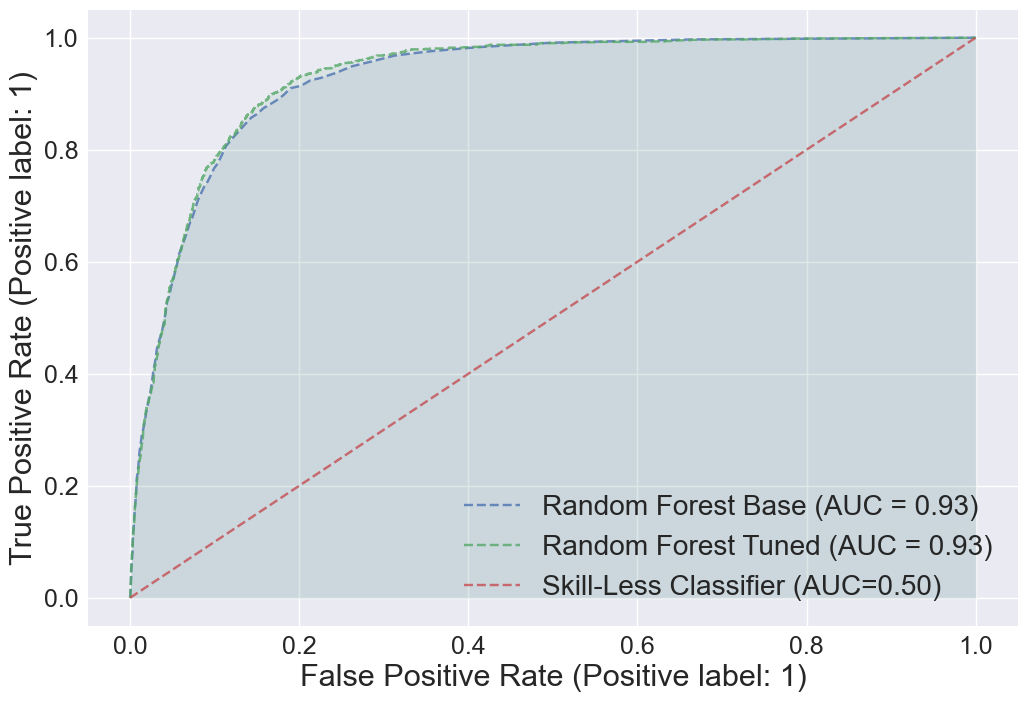

In [32]:
def get_metrics(clfs, X_trains, X_tests, y_trains, y_tests, labels):

    if isinstance(clfs, list):
        for i, clf in enumerate(clfs):
            print('-------------------------------------------------------------------')
            print(labels[i])
            print('\n')
#             preds = predictions(clf, X_trains[i], X_tests[i], y_trains[i], y_test[i])
            print('Train')
            print(classification_report(y_trains[i],clf.predict(X_trains[i])))
            print('Test')
            print(classification_report(y_tests[i],clf.predict(X_tests[i])))
clfs = [rf, rf_drop, rf_drop_gs, rf_smote]
X_trains = [X_train, X_train_drop, X_train_drop, X_train_res_drop]
X_tests = [X_test, X_test_drop, X_test_drop, X_test_drop]
y_trains = [y_train, y_train, y_train, y_train_res_drop]
y_tests = [y_test, y_test, y_test, y_test]
labels = ['Baseline', 'Feature Selection', 'GridSearch', 'SMOTE']

get_metrics(clfs, X_trains, X_tests, y_trains, y_tests, labels)
plt.style.use("seaborn")
plots_dir = Path("../plots/random_forest")

if not plots_dir.is_dir():
    plots_dir.mkdir()
reload(utils)
plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 22,
                    'xtick.labelsize': 18,
                    'ytick.labelsize': 18})

utils.plot_roc_curve([rf_drop, rf_drop_gs], X_test_drop, y_test,
                    labels=["Random Forest Base", "Random Forest Tuned"],
                    subplots_kwargs={"figsize": (12, 8)},
                    save_fpath=plots_dir/"random_forest_roc.png")

plt.show()

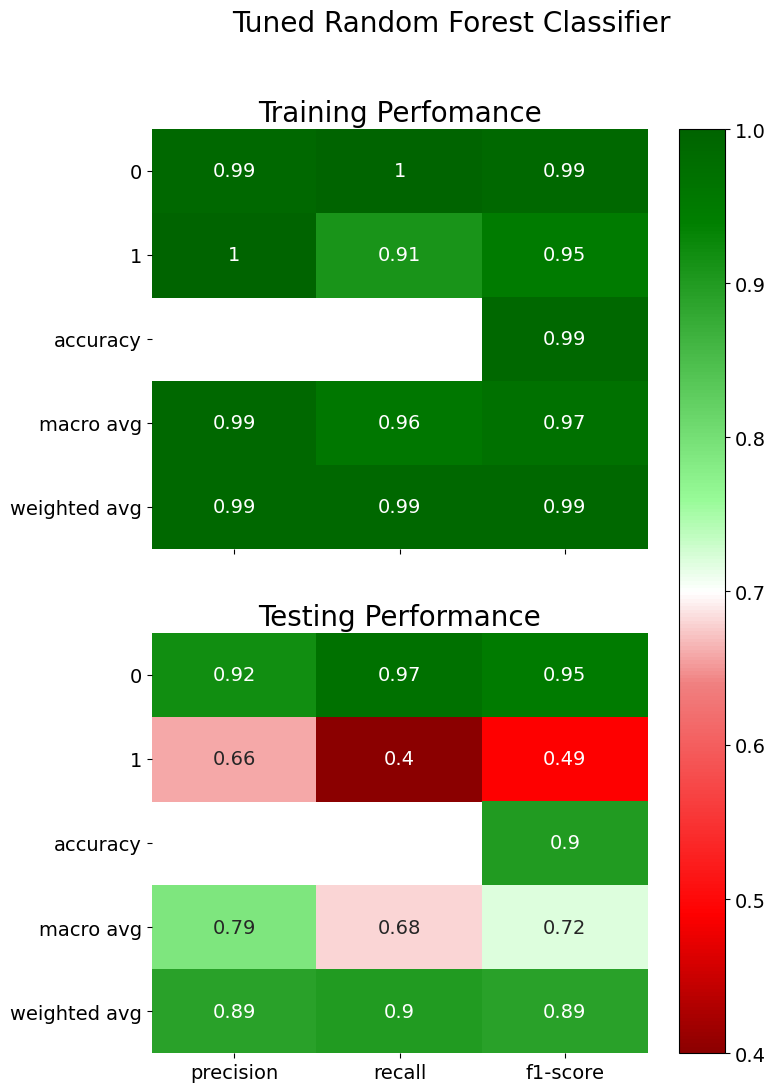

In [30]:
reload(utils)
plt.style.use("default")

plt.rcParams.update({'font.size': 14,
                    'axes.labelsize': 20,
                    'axes.titlesize': 20})

report_df = utils.compare_classification_reports([rf_drop_gs, rf_drop_gs],
                                                 [X_train_drop, X_test_drop],
                                                 [y_train, y_test],
                                                 names=["Training Perfomance", "Testing Performance"],
                                                 suptitle="Tuned Random Forest Classifier",
                                                 plot=True,
                                                 subplot_kwargs=dict(nrows=2, figsize=(8, 12)),
                                                 cbar_orient="vertical",
                                                  save_fpath=plots_dir/"random_forestf_best_report.png")

**The GridSearch seemed to do marginally better than Baseline and Baseline + Feature Selection, as it prevented overfitting**.

In [25]:
models_dir = Path("../models/random_forest")

assert models_dir.is_dir()

data_dir = models_dir/"data"

if not data_dir.is_dir():
    data_dir.mkdir()
    
pickle.dump(rf, open(models_dir/"rf_base.p", "wb"))
pickle.dump(rf_drop, open(models_dir/"rf_drop.p", "wb"))
pickle.dump(rf_drop_gs, open(models_dir/"rf_best.p", "wb"))
pickle.dump(rf_smote, open(models_dir/"rf_smote.p", "wb"))

pickle.dump((X_train, X_train_drop, X_train_res_drop, X_test, X_test_drop, y_train, y_train_res_drop, y_test), open(data_dir/"data.p", "wb"))

pickle.dump(low_features, open(models_dir/"low_importance_features.p", "wb"))

with open(models_dir/"README.md", "w") as f:
    f.write(f"""
    ## Adaboost models trained on SMOTE resampled data
    Contents:
    - `rf_base.p` - trained RandomForestClassifier instance (baseline classifier)
    - `rf_drop.p` - trained RandomForestClassifier instance (baseline classifier with dropped features)
    - `rf_best.p` - trained RandomForestClassifier instance (baseline classifier with dropped features and GridSearch)
    - `rf_smote.p` - trained RandomForestClassifier instance (baseline classifier with dropped features and SMOTE)
    - `data.p` - data tuple (X_train, X_drop, X_train_res_drop, X_test, X_test_drop, y_train, y_train_res_drop, y_test)
    - `low_importance_features.p` - pd Series of low importance features
    The following low importance features have been dropped:
    {str(low_features.index.values)}
    """)